In [108]:
# run results of DragDiffusion
import argparse
import os
import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import PIL
from PIL import Image

from copy import deepcopy
from einops import rearrange
from types import SimpleNamespace

from diffusers import DDIMScheduler, AutoencoderKL
from torchvision.utils import save_image
from pytorch_lightning import seed_everything

import sys
sys.path.insert(0, '../')
from drag_pipeline import DragPipeline

from utils.drag_utils import drag_diffusion_update
from utils.attn_utils import register_attention_editor_diffusers, MutualSelfAttentionControl

import matplotlib.pyplot as plt

In [122]:
def get_features_plus(feature, position):
    # feature: (1,C,H,W)
    # position: (N,2)
    # return: (N,C)
    device = feature.device

    y = position[:, 0]
    x = position[:, 1]

    x0 = x.long()
    x1 = x0 + 1
    y0 = y.long()
    y1 = y0 + 1

    wa = ((x1.float() - x) * (y1.float() - y)).to(device).unsqueeze(1).detach()
    wb = ((x1.float() - x) * (y - y0.float())).to(device).unsqueeze(1).detach()
    wc = ((x - x0.float()) * (y1.float() - y)).to(device).unsqueeze(1).detach()
    wd = ((x - x0.float()) * (y - y0.float())).to(device).unsqueeze(1).detach()

    Ia = feature[:, :, y0, x0].squeeze(0).transpose(1, 0)
    Ib = feature[:, :, y1, x0].squeeze(0).transpose(1, 0)
    Ic = feature[:, :, y0, x1].squeeze(0).transpose(1, 0)
    Id = feature[:, :, y1, x1].squeeze(0).transpose(1, 0)

    output = Ia * wa + Ib * wb + Ic * wc + Id * wd
    return output

def get_position_for_feature(win_r):
    k = torch.linspace(-win_r, win_r, steps=2 * win_r + 1)
    k1 = k.repeat(2 * win_r + 1, 1).transpose(1, 0).flatten(0).unsqueeze(0)
    k2 = k.repeat(1, 2 * win_r + 1)
    return torch.cat((k1, k2), dim=0).transpose(1, 0)

def get_features_plus2(feature, position):
    # feature: (1,C,H,W)
    # position: (N,2)
    # return: (N,C)
    device = feature.device

    y = position[:, 0]
    x = position[:, 1]

    x0 = x.long()
    x1 = x0 + 1
    y0 = y.long()
    y1 = y0 + 1

    wa = ((x1.float() - x) * (y1.float() - y)).to(device).unsqueeze(1).detach()
    wb = ((x1.float() - x) * (y - y0.float())).to(device).unsqueeze(1).detach()
    wc = ((x - x0.float()) * (y1.float() - y)).to(device).unsqueeze(1).detach()
    wd = ((x - x0.float()) * (y - y0.float())).to(device).unsqueeze(1).detach()

    # print(wa)
    # print(wb)
    # print(wc)
    # print(wd)


    Ia = feature[:, :, y0, x0].squeeze(0).transpose(1, 0)
    Ib = feature[:, :, y1, x0].squeeze(0).transpose(1, 0)
    Ic = feature[:, :, y0, x1].squeeze(0).transpose(1, 0)
    Id = feature[:, :, y1, x1].squeeze(0).transpose(1, 0)

    output = Ia * wa + Ib * wb + Ic * wc + Id * wd
    return output

f = torch.ones(1, 3, 28, 28) * torch.tensor([[[[1]], [[2]], [[3]]]])
p = torch.tensor([[5, 5]]) + get_position_for_feature(1)
(get_features_plus2(f, p)).shape

torch.Size([9, 3])

In [123]:
f = torch.randn(1, 3, 10, 10)
t = torch.randn(1, 3, 10, 10)

l1_loss = torch.nn.L1Loss(reduction='sum')

l1_loss(f, t), l1_loss(f.sum(-1), t.sum(-1)), l1_loss(f.sum(), t.sum()), l1_loss(f.sum(), t.sum())

(tensor(342.0455), tensor(111.2087), tensor(8.1087), tensor(8.1087))

In [169]:
all_category = [
        'art_work',
        'land_scape',
        'building_city_view',
        'building_countryside_view',
        'animals',
        'human_head',
        'human_upper_body',
        'human_full_body',
        'interior_design',
        'other_objects',
    ]
root_dir = 'drag_bench_data'

for cat in all_category:
    file_dir = os.path.join(root_dir, cat)
    print(file_dir, os.listdir(file_dir).__len__())
    # for sample_name in os.listdir(file_dir):
    #     if sample_name == '.DS_Store':
    #         continue
    #     sample_path = os.path.join(file_dir, sample_name)
    #     print(sample_path)

drag_bench_data/art_work 36
drag_bench_data/land_scape 23
drag_bench_data/building_city_view 22
drag_bench_data/building_countryside_view 23
drag_bench_data/animals 21
drag_bench_data/human_head 11
drag_bench_data/human_upper_body 11
drag_bench_data/human_full_body 11
drag_bench_data/interior_design 21
drag_bench_data/other_objects 36


In [171]:
all_category = [
        'art_work',
        'land_scape',
        'building_city_view',
        'building_countryside_view',
        'animals',
        'human_head',
        'human_upper_body',
        'human_full_body',
        'interior_design',
        'other_objects',
    ]
root_dir = 'freedrag_diffusion_res_80_0.7_0.01_3_reduce_dims=(0)_n_step=300_d_max=1.5_l_expected=0.15_L1m=True_L1p=True_L1mask=True'

for cat in all_category:
    file_dir = os.path.join(root_dir, cat)
    print(file_dir, os.listdir(file_dir).__len__())
    # print(os.listdir(file_dir))
    # break
    # for sample_name in os.listdir(file_dir):
    #     if sample_name == '.DS_Store':
    #         continue
    #     sample_path = os.path.join(file_dir, sample_name)
    #     print(sample_path)

freedrag_diffusion_res_80_0.7_0.01_3_reduce_dims=(0)_n_step=300_d_max=1.5_l_expected=0.15_L1m=True_L1p=True_L1mask=True/art_work 35
freedrag_diffusion_res_80_0.7_0.01_3_reduce_dims=(0)_n_step=300_d_max=1.5_l_expected=0.15_L1m=True_L1p=True_L1mask=True/land_scape 22
freedrag_diffusion_res_80_0.7_0.01_3_reduce_dims=(0)_n_step=300_d_max=1.5_l_expected=0.15_L1m=True_L1p=True_L1mask=True/building_city_view 21
freedrag_diffusion_res_80_0.7_0.01_3_reduce_dims=(0)_n_step=300_d_max=1.5_l_expected=0.15_L1m=True_L1p=True_L1mask=True/building_countryside_view 22
freedrag_diffusion_res_80_0.7_0.01_3_reduce_dims=(0)_n_step=300_d_max=1.5_l_expected=0.15_L1m=True_L1p=True_L1mask=True/animals 20
freedrag_diffusion_res_80_0.7_0.01_3_reduce_dims=(0)_n_step=300_d_max=1.5_l_expected=0.15_L1m=True_L1p=True_L1mask=True/human_head 10
freedrag_diffusion_res_80_0.7_0.01_3_reduce_dims=(0)_n_step=300_d_max=1.5_l_expected=0.15_L1m=True_L1p=True_L1mask=True/human_upper_body 10
freedrag_diffusion_res_80_0.7_0.01_3_r

In [142]:
p = torch.tensor([[200, 200]]) + get_position_for_feature(5)
(get_features_plus2(test, p)).shape

torch.Size([121, 3])

In [150]:
torch.norm(p, p=1)/p.flatten().shape[0], p.abs().mean()

(tensor(200.), tensor(200.))

In [163]:
torch.randn(10, 5).sum(()).shape

torch.Size([])

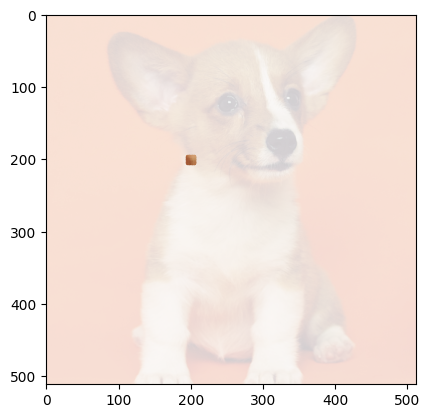

In [144]:
plt.imshow(source_image, alpha=0.2)
for pos, feat in zip(p, get_features_plus2(test, p)):
    plt.scatter(pos[0], pos[1], c=[feat.numpy()/255], s=2)

In [111]:
from run_drag_diffusion import preprocess_image

In [112]:
sample_name = 'JH_2023-09-14-1820-16'

sample_path = os.path.join('drag_bench_data', 'animals', sample_name)

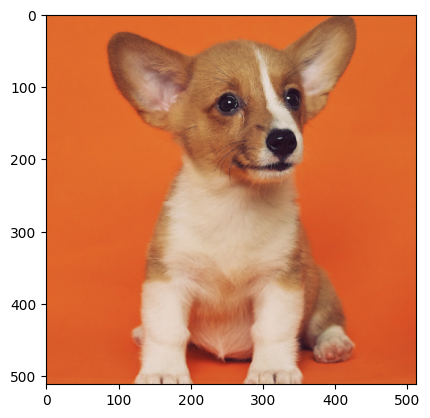

In [113]:
source_image = Image.open(os.path.join(sample_path, 'original_image.png'))
source_image = np.array(source_image)

# load meta data
with open(os.path.join(sample_path, 'meta_data.pkl'), 'rb') as f:
    meta_data = pickle.load(f)
prompt = meta_data['prompt']
mask = meta_data['mask']
points = meta_data['points']

plt.imshow(source_image)

In [5]:
prompt

'a photo of a dog'

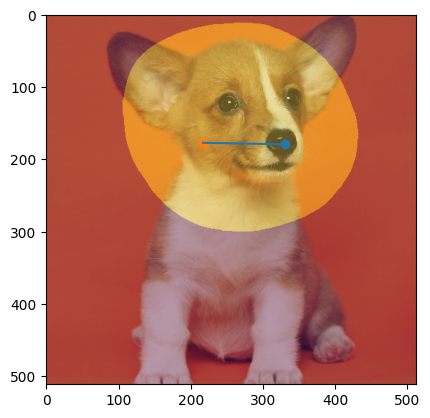

In [6]:
plt.imshow(source_image)
plt.imshow(mask, alpha=0.3)
for p, t in zip(points[::2], points[1::2]):
    plt.plot([p[0], t[0]], [p[1], t[1]])
    plt.scatter(p[0], p[1])
    plt.scatter(t[0], t[1])

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012,
                      beta_schedule="scaled_linear", clip_sample=False,
                      set_alpha_to_one=False, steps_offset=1)
model = DragPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", scheduler=scheduler).to(device)
# call this function to override unet forward function,
# so that intermediate features are returned after forward
model.modify_unet_forward()

# set vae
# if vae_path != "default":
#     model.vae = AutoencoderKL.from_pretrained(
#         vae_path
#     ).to(model.vae.device, model.vae.dtype)

# initialize parameters
seed = 42 # random seed used by a lot of people for unknown reason
seed_everything(seed)

args = SimpleNamespace()
args.prompt = prompt
args.points = points
args.n_inference_step = 50
args.n_actual_inference_step = round(0.7 * args.n_inference_step) # = 50
args.guidance_scale = 1.0

unet_feature_idx = 3
args.unet_feature_idx = [unet_feature_idx]

args.r_m = 1
args.r_p = 3
args.lam = 0.1

args.lr = 0.01
args.n_pix_step = 80

full_h, full_w = source_image.shape[:2]
args.sup_res_h = int(0.5*full_h)
args.sup_res_w = int(0.5*full_w)

/home/jbaljan/dragdiffusion/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  8.79it/s]
Seed set to 42


In [8]:
args

namespace(prompt='a photo of a dog',
          points=[[331, 179], [217, 177]],
          n_inference_step=50,
          n_actual_inference_step=35,
          guidance_scale=1.0,
          unet_feature_idx=[3],
          r_m=1,
          r_p=3,
          lam=0.1,
          lr=0.01,
          n_pix_step=80,
          sup_res_h=256,
          sup_res_w=256)

In [9]:
preproc_source_image = preprocess_image(source_image, device)

preproc_source_image.shape

torch.Size([1, 3, 512, 512])

In [10]:
lora_dir = 'drag_bench_lora'
lora_steps = 80

lora_path = os.path.join(lora_dir, 'animals', sample_name, str(lora_steps))

model.unet.load_attn_procs(lora_path)

In [11]:
invert_code = model.invert(preproc_source_image,
                           prompt,
                           guidance_scale=args.guidance_scale,
                           num_inference_steps=args.n_inference_step,
                           num_actual_inference_steps=args.n_actual_inference_step)

latents shape:  torch.Size([1, 4, 64, 64])
Valid timesteps:  tensor([  1,  21,  41,  61,  81, 101, 121, 141, 161, 181, 201, 221, 241, 261,
        281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501, 521, 541,
        561, 581, 601, 621, 641, 661, 681, 701, 721, 741, 761, 781, 801, 821,
        841, 861, 881, 901, 921, 941, 961, 981])


DDIM Inversion: 100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


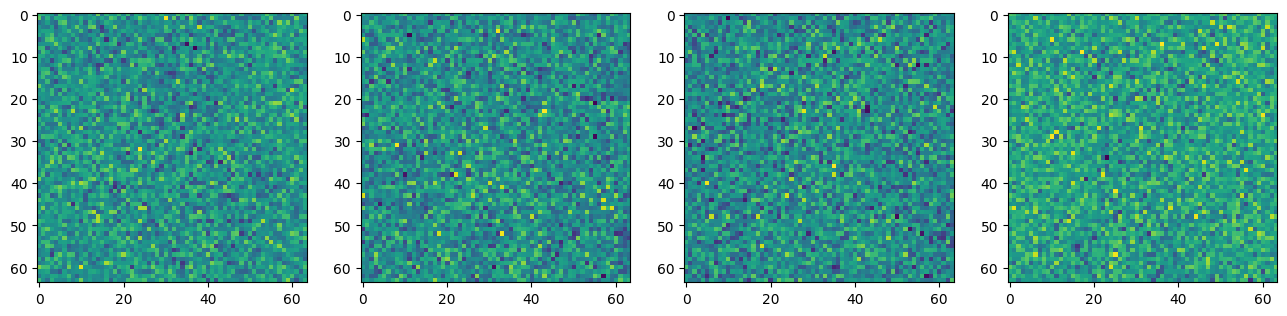

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes = axes.flatten()

for ax, c in zip(axes, invert_code.squeeze()):
    ax.imshow(c.cpu().detach().numpy())

In [13]:
mask = torch.from_numpy(mask).float() / 255.
mask[mask > 0.0] = 1.0
mask = rearrange(mask, "h w -> 1 1 h w").cuda()
mask = F.interpolate(mask, (args.sup_res_h, args.sup_res_w), mode="nearest")

mask.shape

torch.Size([1, 1, 256, 256])

In [14]:
handle_points = []
target_points = []
# here, the point is in x,y coordinate
for idx, point in enumerate(points):
    cur_point = torch.tensor([point[1]/full_h*args.sup_res_h, point[0]/full_w*args.sup_res_w])
    cur_point = torch.round(cur_point)
    if idx % 2 == 0:
        handle_points.append(cur_point)
    else:
        target_points.append(cur_point)
print('handle points:', handle_points)
print('target points:', target_points)

handle points: [tensor([ 90., 166.])]
target points: [tensor([ 88., 108.])]


In [15]:
init_code = invert_code
init_code_orig = deepcopy(init_code)
model.scheduler.set_timesteps(args.n_inference_step)
t = model.scheduler.timesteps[args.n_inference_step - args.n_actual_inference_step]

t

tensor(681)

In [16]:
50-(args.n_inference_step - args.n_actual_inference_step)

35

In [17]:
# the init output feature of unet
with torch.no_grad():
    unet_output, F0 = model.forward_unet_features(init_code, t,
        encoder_hidden_states=model.get_text_embeddings(args.prompt),
        layer_idx=args.unet_feature_idx, interp_res_h=args.sup_res_h, interp_res_w=args.sup_res_w)
    x_prev_0,_ = model.step(unet_output, t, init_code)
    # init_code_orig = copy.deepcopy(init_code)

unet_output.shape, F0.shape, x_prev_0.shape

(torch.Size([1, 4, 64, 64]),
 torch.Size([1, 640, 256, 256]),
 torch.Size([1, 4, 64, 64]))

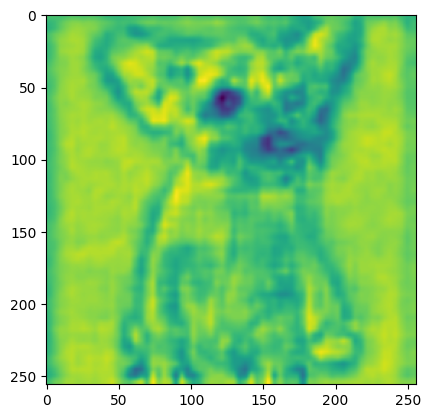

In [18]:
plt.imshow(F0.squeeze().mean(0).cpu().detach().numpy())

In [19]:
# prepare optimizable init_code and optimizer
init_code.requires_grad_(True)
optimizer = torch.optim.Adam([init_code], lr=args.lr)

In [20]:
import copy
# prepare for point tracking and background regularization
handle_points_init = copy.deepcopy(handle_points)
interp_mask = F.interpolate(mask, (init_code.shape[2],init_code.shape[3]), mode='nearest')
using_mask = interp_mask.sum() != 0.0

In [21]:
def point_tracking(F0,
                   F1,
                   handle_points,
                   handle_points_init,
                   args):
    with torch.no_grad():
        _, _, max_r, max_c = F0.shape
        for i in range(len(handle_points)):
            pi0, pi = handle_points_init[i], handle_points[i]
            f0 = F0[:, :, int(pi0[0]), int(pi0[1])]

            r1, r2 = max(0,int(pi[0])-args.r_p), min(max_r,int(pi[0])+args.r_p+1)
            c1, c2 = max(0,int(pi[1])-args.r_p), min(max_c,int(pi[1])+args.r_p+1)
            F1_neighbor = F1[:, :, r1:r2, c1:c2]
            all_dist = (f0.unsqueeze(dim=-1).unsqueeze(dim=-1) - F1_neighbor).abs().sum(dim=1)
            all_dist = all_dist.squeeze(dim=0)
            row, col = divmod(all_dist.argmin().item(), all_dist.shape[-1])
            # handle_points[i][0] = pi[0] - args.r_p + row
            # handle_points[i][1] = pi[1] - args.r_p + col
            handle_points[i][0] = r1 + row
            handle_points[i][1] = c1 + col
        return handle_points

def check_handle_reach_target(handle_points,
                              target_points):
    # dist = (torch.cat(handle_points,dim=0) - torch.cat(target_points,dim=0)).norm(dim=-1)
    all_dist = list(map(lambda p,q: (p-q).norm(), handle_points, target_points))
    return (torch.tensor(all_dist) < 2.0).all()

# obtain the bilinear interpolated feature patch centered around (x, y) with radius r
def interpolate_feature_patch(feat,
                              y1,
                              y2,
                              x1,
                              x2):
    x1_floor = torch.floor(x1).long()
    x1_cell = x1_floor + 1
    dx = torch.floor(x2).long() - torch.floor(x1).long()

    y1_floor = torch.floor(y1).long()
    y1_cell = y1_floor + 1
    dy = torch.floor(y2).long() - torch.floor(y1).long()

    wa = (x1_cell.float() - x1) * (y1_cell.float() - y1)
    wb = (x1_cell.float() - x1) * (y1 - y1_floor.float())
    wc = (x1 - x1_floor.float()) * (y1_cell.float() - y1)
    wd = (x1 - x1_floor.float()) * (y1 - y1_floor.float())

    Ia = feat[:, :, y1_floor : y1_floor+dy, x1_floor : x1_floor+dx]
    Ib = feat[:, :, y1_cell : y1_cell+dy, x1_floor : x1_floor+dx]
    Ic = feat[:, :, y1_floor : y1_floor+dy, x1_cell : x1_cell+dx]
    Id = feat[:, :, y1_cell : y1_cell+dy, x1_cell : x1_cell+dx]

    return Ia * wa + Ib * wb + Ic * wc + Id * wd

In [22]:
history = []

# prepare amp scaler for mixed-precision training
scaler = torch.cuda.amp.GradScaler()
for step_idx in range(args.n_pix_step):
    with torch.autocast(device_type='cuda', dtype=torch.float16):
        unet_output, F1 = model.forward_unet_features(init_code, t,
            encoder_hidden_states=model.get_text_embeddings(args.prompt),
            layer_idx=args.unet_feature_idx, interp_res_h=args.sup_res_h, interp_res_w=args.sup_res_w)
        x_prev_updated,_ = model.step(unet_output, t, init_code)

        history.append(torch.clone(F1).detach().cpu())

        # do point tracking to update handle points before computing motion supervision loss
        if step_idx != 0:
            handle_points = point_tracking(F0, F1, handle_points, handle_points_init, args)
            print('new handle points', handle_points)

        # break if all handle points have reached the targets
        if check_handle_reach_target(handle_points, target_points):
            break

        loss = 0.0
        _, _, max_r, max_c = F0.shape
        for i in range(len(handle_points)):
            pi, ti = handle_points[i], target_points[i]
            # skip if the distance between target and source is less than 1
            if (ti - pi).norm() < 2.:
                continue

            di = (ti - pi) / (ti - pi).norm()

            # motion supervision
            # with boundary protection
            r1, r2 = max(0,int(pi[0])-args.r_m), min(max_r,int(pi[0])+args.r_m+1)
            c1, c2 = max(0,int(pi[1])-args.r_m), min(max_c,int(pi[1])+args.r_m+1)
            f0_patch = F1[:,:,r1:r2, c1:c2].detach()
            f1_patch = interpolate_feature_patch(F1,r1+di[0],r2+di[0],c1+di[1],c2+di[1])

            # original code, without boundary protection
            # f0_patch = F1[:,:,int(pi[0])-args.r_m:int(pi[0])+args.r_m+1, int(pi[1])-args.r_m:int(pi[1])+args.r_m+1].detach()
            # f1_patch = interpolate_feature_patch(F1, pi[0] + di[0], pi[1] + di[1], args.r_m)
            loss += ((2*args.r_m+1)**2)*F.l1_loss(f0_patch, f1_patch)

        # masked region must stay unchanged
        if using_mask:
            loss += args.lam * ((x_prev_updated-x_prev_0)*(1.0-interp_mask)).abs().sum()
        # loss += args.lam * ((init_code_orig-init_code)*(1.0-interp_mask)).abs().sum()
        print('loss total=%f'%(loss.item()))

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad()

/tmp/ipykernel_2787726/955866175.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


loss total=5.057148
new handle points [tensor([ 90., 166.])]
loss total=16.517456
new handle points [tensor([ 90., 166.])]
loss total=15.923134
new handle points [tensor([ 90., 166.])]
loss total=11.253155
new handle points [tensor([ 90., 166.])]
loss total=5.596890
new handle points [tensor([ 90., 166.])]
loss total=8.987734
new handle points [tensor([ 90., 165.])]
loss total=8.831661
new handle points [tensor([ 90., 165.])]
loss total=7.968252
new handle points [tensor([ 90., 165.])]
loss total=8.212328
new handle points [tensor([ 90., 165.])]
loss total=7.428662
new handle points [tensor([ 90., 165.])]
loss total=6.535598
new handle points [tensor([ 90., 165.])]
loss total=6.838968
new handle points [tensor([ 90., 164.])]
loss total=7.634617
new handle points [tensor([ 90., 164.])]
loss total=7.774114
new handle points [tensor([ 90., 164.])]
loss total=8.180433
new handle points [tensor([ 90., 164.])]
loss total=8.180433
new handle points [tensor([ 90., 164.])]
loss total=7.894525
n

In [23]:
len(history), history[0].shape

(80, torch.Size([1, 640, 256, 256]))

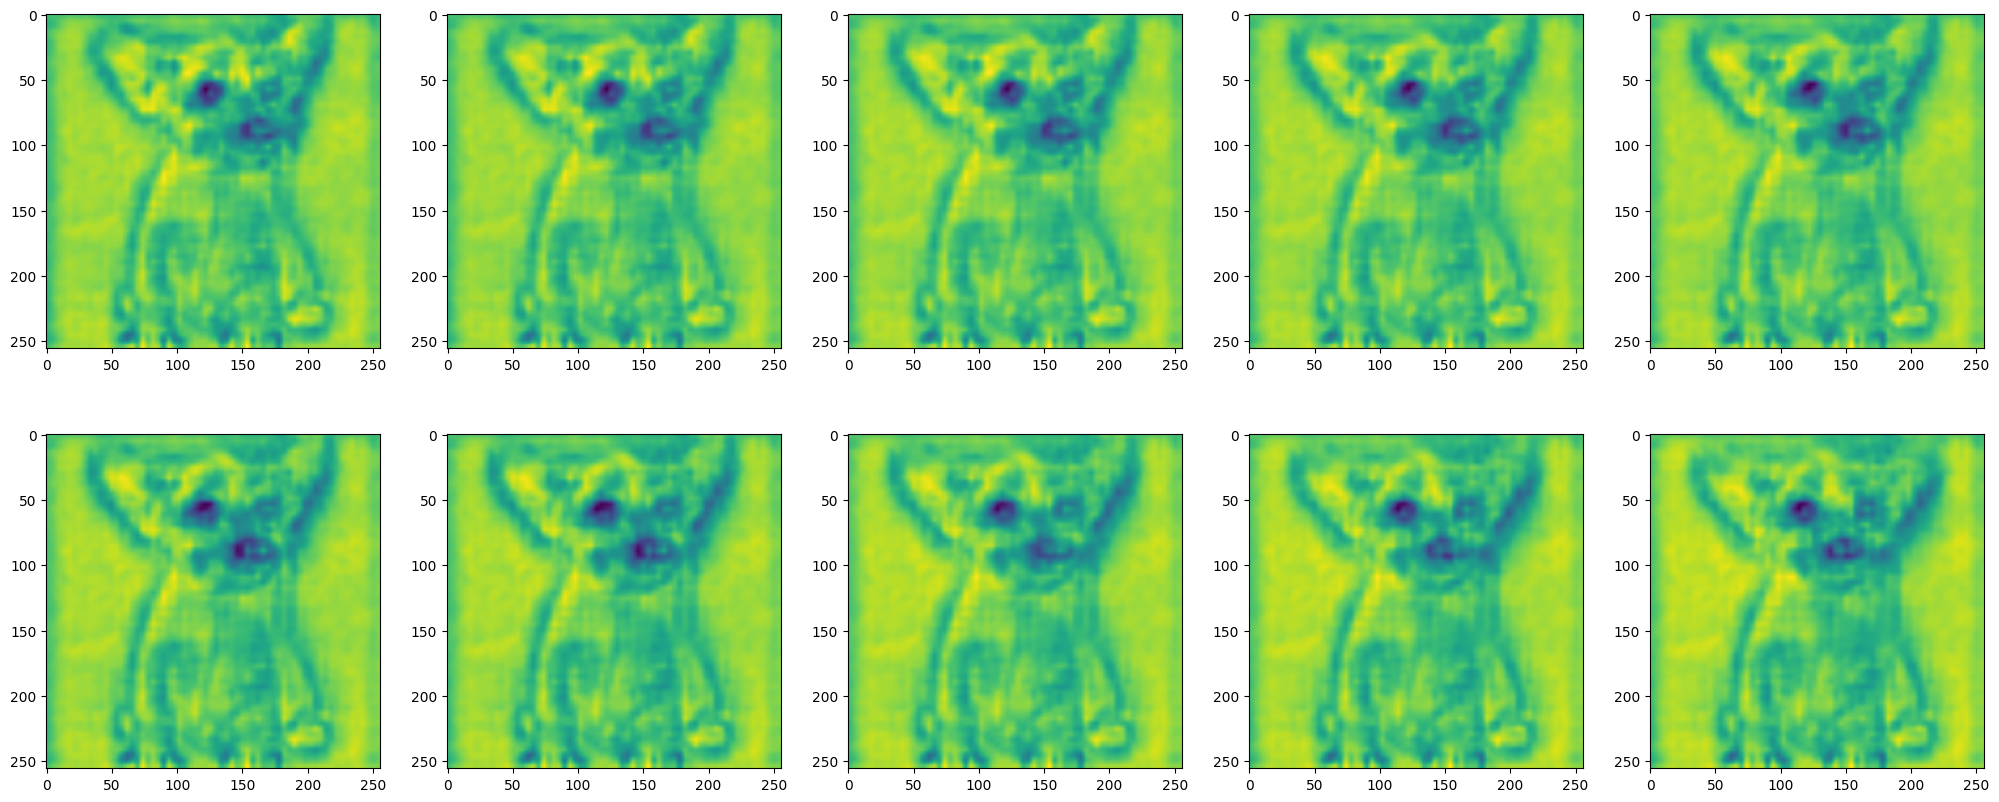

In [24]:
fig, axes = plt.subplots(2, 5, figsize=(5*5, 5*2))
axes = axes.flatten()

for ax, f1 in zip(axes, history[:40:4]):
    ax.imshow(f1.squeeze().mean(0).cpu().detach().numpy())

In [25]:
updated_init_code = drag_diffusion_update(model, init_code,
    None, t, handle_points, target_points, mask, args)

# hijack the attention module
# inject the reference branch to guide the generation
editor = MutualSelfAttentionControl(start_step=0,
                                    start_layer=10,
                                    total_steps=args.n_inference_step,
                                    guidance_scale=args.guidance_scale)

register_attention_editor_diffusers(model, editor, attn_processor='lora_attn_proc')

# inference the synthesized image
gen_image = model(
    prompt=args.prompt,
    batch_size=2,
    latents=torch.cat([init_code_orig, updated_init_code], dim=0),
    guidance_scale=args.guidance_scale,
    num_inference_steps=args.n_inference_step,
    num_actual_inference_steps=args.n_actual_inference_step
    )[1].unsqueeze(dim=0)

# resize gen_image into the size of source_image
# we do this because shape of gen_image will be rounded to multipliers of 8
gen_image = F.interpolate(gen_image, (full_h, full_w), mode='bilinear')

gen_image.shape

/home/jbaljan/dragdiffusion/drag_bench_evaluation/../utils/drag_utils.py:111: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


loss total=5.443662
new handle points [tensor([ 91., 132.])]
loss total=16.909477
new handle points [tensor([ 91., 131.])]
loss total=15.688254
new handle points [tensor([ 91., 131.])]
loss total=15.688254
new handle points [tensor([ 91., 131.])]
loss total=11.147701
new handle points [tensor([ 91., 131.])]
loss total=6.027602
new handle points [tensor([ 91., 131.])]
loss total=9.558491
new handle points [tensor([ 91., 130.])]
loss total=10.185855
new handle points [tensor([ 91., 130.])]
loss total=9.406775
new handle points [tensor([ 91., 128.])]
loss total=9.442142
new handle points [tensor([ 91., 128.])]
loss total=8.622761
new handle points [tensor([ 91., 128.])]
loss total=7.632481
new handle points [tensor([ 91., 128.])]
loss total=8.104495
new handle points [tensor([ 91., 127.])]
loss total=8.095928
new handle points [tensor([ 91., 127.])]
loss total=8.263015
new handle points [tensor([ 90., 127.])]
loss total=8.348243
new handle points [tensor([ 90., 127.])]
loss total=7.793140

DDIM Sampler: 100%|██████████| 50/50 [00:05<00:00,  8.50it/s]


torch.Size([1, 3, 512, 512])

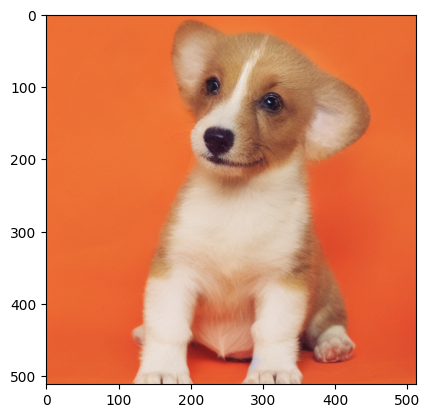

In [26]:
out_image = gen_image.cpu().permute(0, 2, 3, 1).numpy()[0]
out_image = (out_image * 255).astype(np.uint8)
plt.imshow(out_image)